# Hex world problem

The hex world problem is a tuple of attributes:
1. hexes: contain all tiles of the game, each tile is represent as pair of integer (coordinate in the board)
2. reward hexes: is a subset of hexes, contain tiles which has reward (also these tiles lead to terminal state) and its correspond reward.
3. reward border: when moving, if agent hit the wall, he will receive this "reward border" (usually negative as a penalty).
4. p_intended: when moving at direction $i$, there are p_intended chance to move as intended and (1 - p_intended)/2 chance to move to two side direction $(i - 1) % 6 + 1$ and $(i + 1) % 6 + 1$.
5. $\gamma$: discount factor for lookahead function.

In [1]:
struct HexWorld
    # each state is coordinate (x, y) of correspond hex tile
    hexes::Vector{Tuple{Int,Int}}
    # some state has reward 
    reward_hexes::Dict{Tuple{Int, Int}, Float64}
    # reward if hit the wall
    reward_border::Float64
    # probability of successfully moving chosen direction
    p_intended::Float64
    # discount factor
    γ::Float64
end

## Action Space

Each hex tile can move to six direction, numbered from 1 to 6, store in `hex_direction` array

In [3]:
# array represent valid direction for hex tile
const hex_direction = [(+1, 0), (+1, -1), (0, -1), (-1, 0), (-1, +1), (0, +1)]
const direction2char = [">", "^>", "<^", "<", "<v", "v>"]

6-element Vector{String}:
 ">"
 "^>"
 "<^"
 "<"
 "<v"
 "v>"

## Value Iterative

Value iteration is an alternative to policy iteration that is often used because of its simplicity. Unlike policy improvement, value iteration updates the value function directly.

The value function can be improved by applying the Bellman equation:
$$U_{k+1} = \max_a\left(R(s,a) + \gamma \sum_{s'}T(s'|s,a)U_k(s')\right)$$

In [4]:

Base.:+(x::Tuple{Int, Int}, y::Tuple{Int, Int}) = (x[1] + y[1], x[2] + y[2])

function get_Qvalue(hex::Tuple{Int,Int}, 
                    a::Int, 
                    p::Float64,
                    hex_world::HexWorld,
                    hex2state::Dict{Tuple{Int, Int}, Int},
                    U::Vector{Float64})
    next_hex = hex + hex_direction[a]
    if !haskey(hex2state, next_hex)
        new_s = hex2state[hex]
        return p * hex_world.reward_border + hex_world.γ * p * U[new_s]
    else
        new_s = hex2state[next_hex]
        return hex_world.γ * p * U[new_s]
    end
end

function bellman_update(hex_world::HexWorld, 
                            U::Vector{Float64}, 
                            hex2state::Dict{Tuple{Int, Int}, Int})
    nS = length(hex_world.hexes)
    nA = length(hex_direction)
    
    Q = zeros(nS, nA)
    p_veer = (1.0 - hex_world.p_intended) / 2
    p_intended = hex_world.p_intended
    for hex in hex_world.hexes
        s = hex2state[hex]
        for a = 1:nA
            if haskey(hex_world.reward_hexes, hex)
                Q[s,a] = hex_world.reward_hexes[hex]
            else
                Q[s,a] += get_Qvalue(hex, a, p_intended, hex_world, hex2state, U)
                Q[s,a] += get_Qvalue(hex, mod1(a - 1, nA), p_veer, hex_world, hex2state, U)
                Q[s,a] += get_Qvalue(hex, mod1(a + 1, nA), p_veer, hex_world, hex2state, U)
            end
        end
    end
    
    new_U, new_policy = findmax(Q, dims = 2)

    return vec(new_U), map(x -> x[2], new_policy)
end

bellman_update (generic function with 1 method)

In [5]:
using LinearAlgebra
function is_terminal(U::Vector{Float64}, new_U::Vector{Float64}, threshold::Float64)
    return LinearAlgebra.norm(U - new_U, 1) <= threshold
end

is_terminal (generic function with 1 method)

In [6]:
function get_optimal_policy(hex_world::HexWorld, max_step::Int, threshold::Float64)
    nS = length(hex_world.hexes)
    U = zeros(nS)
    policy = zeros(nS)
    hex2state = Dict{Tuple{Int, Int}, Int}()
    for (s, hex) in enumerate(hex_world.hexes)
        hex2state[hex] = s
    end
    
    for step = 1 : max_step
        new_U, policy = bellman_update(hex_world, U, hex2state)

        if is_terminal(U, new_U, threshold)
            println("Convergence at step: ", step)
            break
        end

        U = new_U
    end

    return policy, U
end

get_optimal_policy (generic function with 1 method)

# Instance for Experiment

In [ ]:
const REWARD_BORDER = -1.0 # Reward for falling off hex map
const P_INTENDED = 0.7 # Probability of going intended direction
const DISCOUNT_FACTOR = 0.9

const general_hexworld = HexWorld(
    [(1,0), (2,0), (3,0), (4,0), (5,0), (6,0), (7,0), (8,0), (9,0), (10,0),
    (1,1), (2,1), (3,1), (5,1), (8,1), (9,1),
    (0,2), (1,2), (2,2), (3,2), (5,2), (6,2), (7,2), (9,2)],
    Dict{Tuple{Int,Int}, Float64}(
        (1,1) =>  5.0,
        (2,2) => -10.0,
        (9,2) =>  10.0,
    ),
    REWARD_BORDER,
    P_INTENDED,
    DISCOUNT_FACTOR
)

const ring_hexworld = HexWorld(
    [(1,0), (2,0), (3,0), (4,0),
    (0,1), (4,1),
    (0,2), (1,2), (2,2), (3,2)],
    Dict{Tuple{Int,Int}, Float64}(
        (2, 2) => 10.0, # right side reward
    ),
    REWARD_BORDER,
    P_INTENDED,
    DISCOUNT_FACTOR
)

# Result analyzing

In [7]:
include("./PlotHexWorld.jl")

function draw_result(hex_world::HexWorld, optimal_policy, optimal_utility, MARKER_SIZE::Int)
    colormap = cgrad(:RdBu_9)
    umax, _ = findmax(optimal_utility)
    umin, _ = findmin(optimal_utility)
    rescaled_utility = map(u -> (u - umin)/(umax - umin), optimal_utility)

    p = draw_hexgrid(hex_world.hexes, MARKER_SIZE)
    
    for key in keys(hex_world.reward_hexes)
        u = (hex_world.reward_hexes[key] - umin)/(umax - umin)
        i = findfirst(x -> x == key, hex_world.hexes)
        draw_hexbin(p, hex_world.hexes, hex_world.hexes[i], (0,0), colormap[u], MARKER_SIZE)
    end
    display(p)

    for (i, direction) in enumerate(optimal_policy)
        draw_hexbin(p, hex_world.hexes, hex_world.hexes[i], hex_direction[direction], colormap[rescaled_utility[i]], MARKER_SIZE)
    end
    display(p)
end


draw_result (generic function with 1 method)

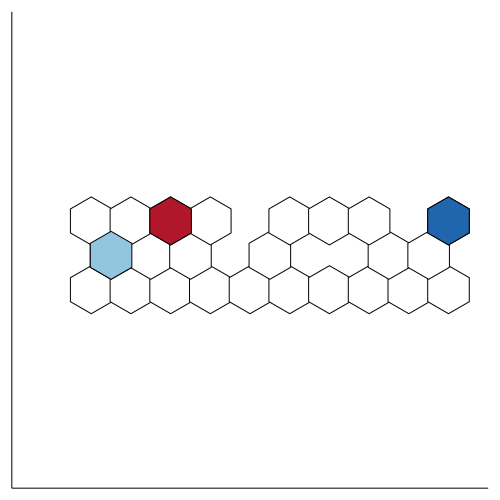

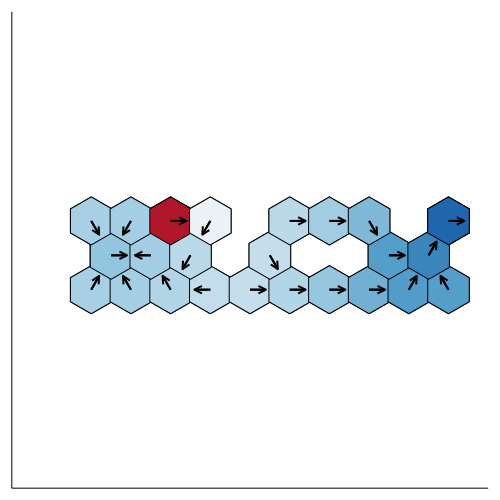

Convergence at step: 47


In [8]:
optimal_policy, optimal_utility = get_optimal_policy(general_hexworld, 100, 0.0)
draw_result(general_hexworld, optimal_policy, optimal_utility, 24)

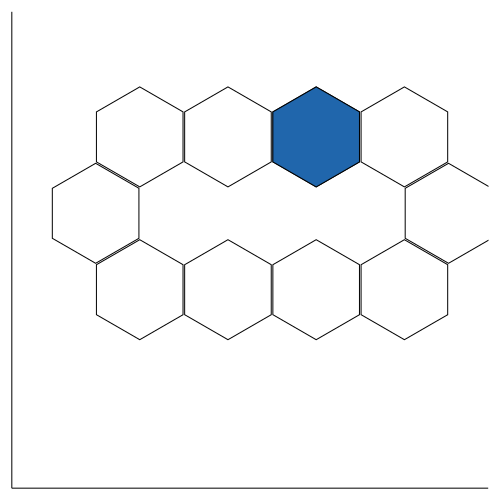

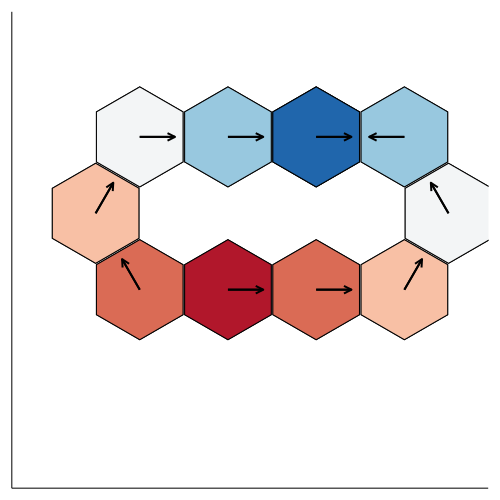

Convergence at step: 42


In [9]:
optimal_policy, optimal_utility = get_optimal_policy(ring_hexworld, 100, 0.0)
draw_result(ring_hexworld, optimal_policy, optimal_utility, 50)

# Monte Carlo Estimation

In [10]:
using Random, Distributions    
Random.seed!(0)

function simulate(hex_world::HexWorld, s, policy)
    nA = length(hex_direction)
    hex2state = Dict{Tuple{Int, Int}, Int}()
    for (s, hex) in enumerate(hex_world.hexes)
        hex2state[hex] = s
    end
    p_veer = (1.0 - hex_world.p_intended) / 2
    p_intended = hex_world.p_intended

    u = 0
    while true
        hex = hex_world.hexes[s]
        # return if reach reward hex
        if haskey(hex_world.reward_hexes, hex)
            u = u + hex_world.reward_hexes[hex]
            return u
        end
        # generate next hex
        a = policy[s]
        S = [a, mod1(a - 1, nA), mod1(a - 1, nA)]
        next_direction = S[rand(Categorical([p_intended, p_veer, p_veer]))]
        next_hex = hex + hex_direction[next_direction]
        if !haskey(hex2state, next_hex)
            next_hex = hex
            u += hex_world.reward_border
        end
        s = hex2state[next_hex]
    end
end

simulate (generic function with 1 method)

In [13]:
function monte_carlo(hex_world::HexWorld, policy, n_step::Int)
    nS = length(hex_world.hexes)
    U = zeros(nS)
    for s in 1:nS
        for k in 1:n_step
            U[s] += simulate(hex_world, s, policy)
        end
        U[s] /= n_step
    end
    return U
end


monte_carlo (generic function with 1 method)

In [17]:
optimal_policy, optimal_utility = get_optimal_policy(general_hexworld, 100, 0.0)
monte_utility = monte_carlo(general_hexworld, optimal_policy, 1000000)
println(monte_utility)
println(optimal_utility)

Convergence at step: 47
[4.572769, 4.871881, 4.935167, 4.50621, 8.365603, 8.495802, 8.925527, 9.353909, 9.443543, 9.532847, 5.0, 4.961483, 4.806802, 8.065815, 9.142312, 9.572237, 4.996535, 4.988439, -10.0, 4.377015, 7.857753, 8.285661, 8.714391, 10.0]
[4.1377814603755985, 4.290229357221428, 3.7467540353005524, 3.079491445840049, 3.0134940431880235, 3.729921669090884, 4.798163203867214, 6.03596688702074, 7.04438270191447, 6.9122241116061, 5.0, 4.308361926449786, 3.357815247498476, 3.0134940431880235, 6.9122241116061, 8.219178082191782, 4.1377814603755985, 4.290229357221427, -10.0, 0.7114723767907971, 3.371243165298099, 4.382551604234305, 5.554385192208004, 10.0]


In [40]:
optimal_policy, optimal_utility = get_optimal_policy(ring_hexworld, 100, 0.0)
monte_utility = monte_carlo(ring_hexworld, optimal_policy, 1000000)
println(monte_utility)
println(optimal_utility)

Convergence at step: 42
[8.285397, 7.858906, 8.284743, 8.713553, 8.715289, 9.142552, 9.144215, 9.570599, 10.0, 9.572182]
[4.211309073685234, 3.223458515646161, 4.211309073685234, 5.355961307603525, 5.355961307603525, 6.682304372302497, 6.682304372302497, 8.219178082191782, 10.0, 8.219178082191782]
